In [1]:
# ============================================================
# 📌 Paso 1: Importar librerías
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [13]:
# ============================================================
# 📌 Paso 2: Cargar el dataset
# ============================================================
# Ajusta la ruta al archivo en tu entorno local o en Google Colab
path = "C:\\Users\\ADM\\Documents\\Nasa\\Exoplanet-detection-using-AI\\data\\TOI_2025.10.04_05.29.26.csv"

toi_df = pd.read_csv(path, comment='#', low_memory=False)
toi_df.head()


,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


In [ ]:
# ============================================================
# 📌 Paso 3: Crear la etiqueta (Confirmed / Candidate = 1, False = 0)
# ============================================================
X = toi_df[['rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhlim', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmaglim', 'st_dist', 'st_disterr1', 'st_disterr2', 'st_distlim', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'toi_created', 'rowupdate']]
y = toi_df["tfopwg_disp"].map({"PC": 1, "FP": 0})

KeyError: "['pl_orbperr2'] not in index"

In [33]:
# ============================================================
# 📌 Paso 4: Selección de variables numéricas
# ============================================================
# Excluir explícitamente columnas que no queremos usar como features numéricas
excluded_cols = {label_col, 'target', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'}
cand_cols = [c for c in df.columns if c not in excluded_cols]
num_cols = []

for c in cand_cols:
    coerced = pd.to_numeric(df[c], errors='coerce')
    if coerced.isna().mean() < 0.9 and coerced.nunique(dropna=True)>1:
        df[c+"_num"] = coerced
        num_cols.append(c+"_num")

X_all = df[num_cols].fillna(df[num_cols].median())
y = df['target'].astype(int)

print("Número de features numéricos:", len(num_cols))


Número de features numéricos: 37


In [34]:
# ============================================================
# 📌 Paso 5: Seleccionar las features más correlacionadas
# ============================================================
corrs = X_all.corrwith(y).abs().sort_values(ascending=False)
top_cols = corrs.index[:20].tolist()  # antes eran 10, ahora 20
X = X_all[top_cols].copy()
print("Top features:", top_cols)

Top features: ['koi_steff_err1_num', 'koi_steff_err2_num', 'koi_teq_num', 'koi_depth_num', 'koi_model_snr_num', 'koi_tce_plnt_num_num', 'koi_steff_num', 'koi_slogg_err2_num', 'koi_duration_num', 'ra_num', 'koi_slogg_num', 'koi_slogg_err1_num', 'koi_impact_err1_num', 'koi_srad_err1_num', 'dec_num', 'kepid_num', 'koi_srad_err2_num', 'koi_srad_num', 'koi_period_err1_num', 'koi_period_err2_num']


In [35]:
# ============================================================
# 📌 Paso 6: Preparar dataset de entrenamiento
# ============================================================
# Reducimos el tamaño para entrenar rápido (útil en deadline corto)
if X.shape[0] > 3000:
    X, _, y, _ = train_test_split(X, y, stratify=y, train_size=3000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [36]:
# ============================================================
# 📌 Paso 7: Definir y entrenar la red neuronal
# ============================================================
mlp = MLPClassifier(
    hidden_layer_sizes=(32,16),  # antes era (16,)
    max_iter=300,                # antes 100
    random_state=42
)
# Usar sample weights en lugar de class_weight (MLPClassifier no acepta class_weight)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
mlp.fit(X_train_s, y_train, sample_weight=sample_weight)

c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [37]:
# ============================================================
# 📌 Paso 8: Evaluación del modelo
# ============================================================
y_pred = mlp.predict(X_test_s)
y_proba = mlp.predict_proba(X_test_s)[:,1]

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       304
           1       0.82      0.83      0.82       296

    accuracy                           0.82       600
   macro avg       0.83      0.83      0.82       600
weighted avg       0.83      0.82      0.83       600

Matriz de confusión:
[[249  55]
 [ 50 246]]
ROC AUC: 0.8926031294452347


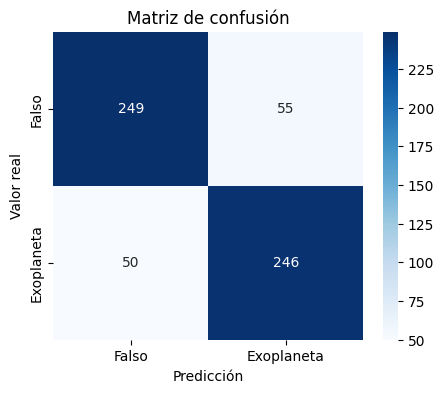

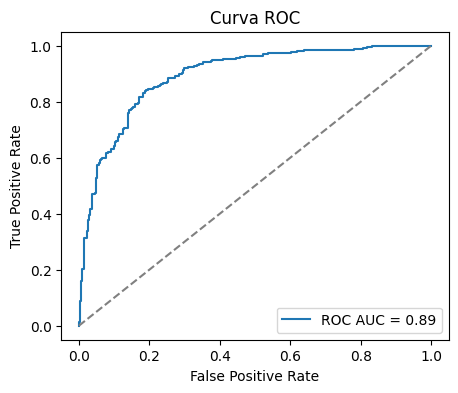

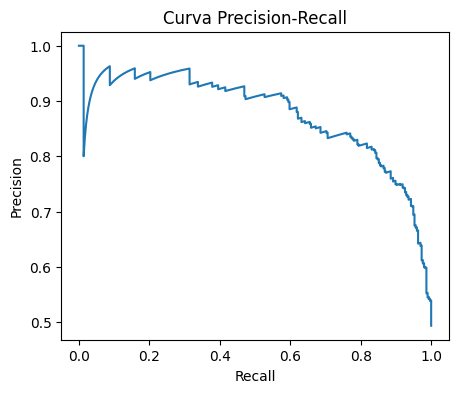

In [38]:
# ============================================================
# 📌 Paso 9: Guardar el modelo entrenado
# ============================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Falso","Exoplaneta"],
            yticklabels=["Falso","Exoplaneta"])
plt.title("Matriz de confusión")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.show()

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test,y_proba):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

# --- Precision-Recall ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.show()


In [39]:
#seleccionar renglon de set de test y mostrar valor real y predicción
def mostrar_valores_prediccion(idx):
    if idx < 0 or idx >= len(X_test):
        print("Índice fuera de rango.")
        return
    fila = X_test.iloc[idx]
    valor_real = y_test.iloc[idx]
    prediccion = mlp.predict(scaler.transform([fila]))[0]
    probabilidad = mlp.predict_proba(scaler.transform([fila]))[0][1]
    #comparar valores reales a valores predichos de los siguientes 20
    print(f"Índice: {idx}")
    print(f"Valor real: {valor_real}, Predicción: {prediccion}, Probabilidad de ser exoplaneta: {probabilidad:.4f}")   

    for i in range(1, 21):
        if idx + i < len(X_test):
            fila_siguiente = X_test.iloc[idx + i]
            valor_real_siguiente = y_test.iloc[idx + i]
            prediccion_siguiente = mlp.predict(scaler.transform([fila_siguiente]))[0]
            probabilidad_siguiente = mlp.predict_proba(scaler.transform([fila_siguiente]))[0][1]
            print(f"Índice: {idx + i}", f"Real: {valor_real_siguiente}, Pred: {prediccion_siguiente}, {probabilidad_siguiente*100:.4f}%")

# Ejemplo de uso:
#mostrar_valores_prediccion(30)  # Cambia el índice para probar otras filas   

#probar con datos que nunca haya visto, siendo estos los "ultimos" del dataset original

print("Últimos 5 registros del dataset original:")
# Usar solo las columnas top_cols para predecir, igual que en entrenamiento
for i in range(50):
    fila = X_all[top_cols].iloc[-(5-i)]
    valor_real = y.iloc[-(5-i)]
    prediccion = mlp.predict(scaler.transform([fila]))[0]
    probabilidad = mlp.predict_proba(scaler.transform([fila]))[0][1]
    print(f"Índice: {len(X_all)-(5-i)}")
    print(f"Valor real: {valor_real}, Predicción: {prediccion}, Probabilidad de ser exoplaneta: {probabilidad:.4f}")


Últimos 5 registros del dataset original:
Índice: 9559
Valor real: 1, Predicción: 0, Probabilidad de ser exoplaneta: 0.0454
Índice: 9560
Valor real: 0, Predicción: 1, Probabilidad de ser exoplaneta: 0.9430
Índice: 9561
Valor real: 1, Predicción: 0, Probabilidad de ser exoplaneta: 0.1400
Índice: 9562
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.8918
Índice: 9563
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.3880
Índice: 9564
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9844
Índice: 9565
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.9997
Índice: 9566
Valor real: 0, Predicción: 0, Probabilidad de ser exoplaneta: 0.3106
Índice: 9567
Valor real: 1, Predicción: 1, Probabilidad de ser exoplaneta: 0.5323
Índice: 9568
Valor real: 0, Predicción: 1, Probabilidad de ser exoplaneta: 0.9826
Índice: 9569
Valor real: 0, Predicción: 1, Probabilidad de ser exoplaneta: 0.7963
Índice: 9570
Valor real: 0, Predicción: 1, Probabilidad 

c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\ADM\Documents\Nasa\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warni

In [40]:
X_train.columns

Index(['koi_steff_err1_num', 'koi_steff_err2_num', 'koi_teq_num',
       'koi_depth_num', 'koi_model_snr_num', 'koi_tce_plnt_num_num',
       'koi_steff_num', 'koi_slogg_err2_num', 'koi_duration_num', 'ra_num',
       'koi_slogg_num', 'koi_slogg_err1_num', 'koi_impact_err1_num',
       'koi_srad_err1_num', 'dec_num', 'kepid_num', 'koi_srad_err2_num',
       'koi_srad_num', 'koi_period_err1_num', 'koi_period_err2_num'],
      dtype='object')

In [41]:
X_train.sample(5)

,koi_steff_err1_num,koi_steff_err2_num,koi_teq_num,koi_depth_num,koi_model_snr_num,koi_tce_plnt_num_num,koi_steff_num,koi_slogg_err2_num,koi_duration_num,ra_num,koi_slogg_num,koi_slogg_err1_num,koi_impact_err1_num,koi_srad_err1_num,dec_num,kepid_num,koi_srad_err2_num,koi_srad_num,koi_period_err1_num,koi_period_err2_num
1012,83.0,-72.0,1028.0,252.9,21.8,1.0,5557.0,-0.090,5.90800,297.79691,4.037,0.210,0.4480,0.254,39.921371,4860678,-0.413,1.616,8.015000e-05,-8.015000e-05
5667,80.0,-80.0,1840.0,243.1,66.7,1.0,5959.0,-0.070,1.67200,290.33612,3.829,0.210,0.1160,0.278,40.653061,5443775,-0.649,2.382,3.902000e-06,-3.902000e-06
4350,173.0,-198.0,330.0,82.3,8.0,1.0,6471.0,-0.208,19.04000,289.22470,4.141,0.270,0.3043,0.418,40.260818,5090803,-0.339,1.302,5.023000e-02,-5.023000e-02
8897,74.0,-80.0,929.0,174010.0,7486.2,1.0,6237.0,-0.126,6.01687,292.51321,4.145,0.154,0.0030,0.301,40.827560,5622250,-0.274,1.508,3.830000e-07,-3.830000e-07
8558,203.0,-248.0,1371.0,141390.0,6579.3,1.0,6258.0,-0.116,4.14104,298.44855,3.882,0.464,0.0510,0.505,45.104176,8906676,-0.938,2.111,1.400000e-07,-1.400000e-07


Guardado: models/feature_importances_by_weight.csv

Top 20 features por norma de pesos:
                 feature  weight_norm
0          koi_depth_num     2.585496
1            koi_teq_num     2.142327
2      koi_srad_err1_num     2.098260
3     koi_slogg_err2_num     2.011198
4          koi_steff_num     1.945396
5    koi_impact_err1_num     1.877557
6       koi_duration_num     1.868491
7    koi_period_err1_num     1.821832
8      koi_srad_err2_num     1.816386
9     koi_slogg_err1_num     1.797926
10  koi_tce_plnt_num_num     1.777122
11                ra_num     1.758025
12     koi_model_snr_num     1.746220
13   koi_period_err2_num     1.711036
14    koi_steff_err2_num     1.686310
15               dec_num     1.574271
16          koi_srad_num     1.502831
17    koi_steff_err1_num     1.443199
18             kepid_num     1.367729
19         koi_slogg_num     1.344293


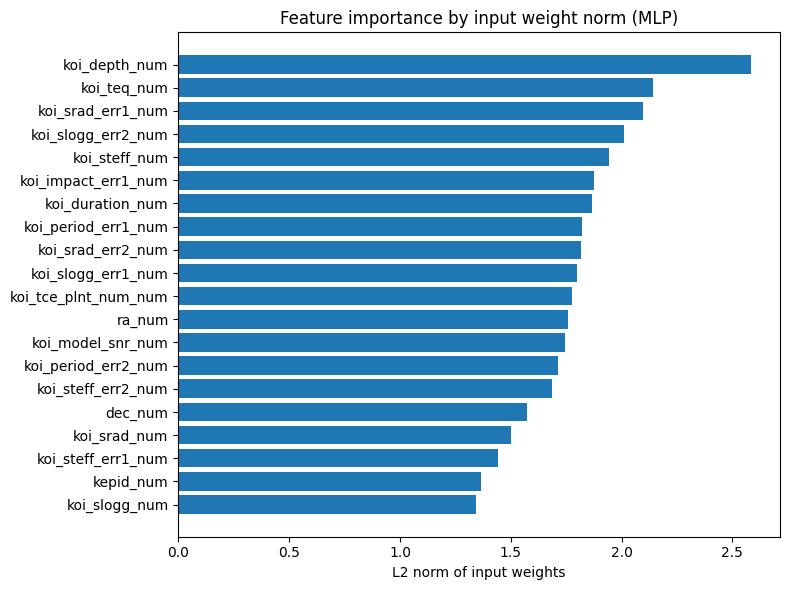


Computando Permutation Importance (esto puede tardar)...
Guardado: models/feature_importances_by_permutation.csv

Top 20 features por Permutation Importance:
                 feature  perm_importance
0            koi_teq_num         0.132626
1          koi_depth_num         0.109197
2     koi_steff_err2_num         0.049651
3       koi_duration_num         0.037728
4     koi_steff_err1_num         0.037471
5      koi_srad_err1_num         0.035667
6                dec_num         0.029895
7    koi_period_err1_num         0.028423
8   koi_tce_plnt_num_num         0.023709
9          koi_steff_num         0.022255
10   koi_impact_err1_num         0.021611
11   koi_period_err2_num         0.019201
12             kepid_num         0.016020
13         koi_slogg_num         0.015189
14    koi_slogg_err1_num         0.014846
15     koi_model_snr_num         0.009906
16    koi_slogg_err2_num         0.008245
17     koi_srad_err2_num         0.007077
18          koi_srad_num         0.004143
1

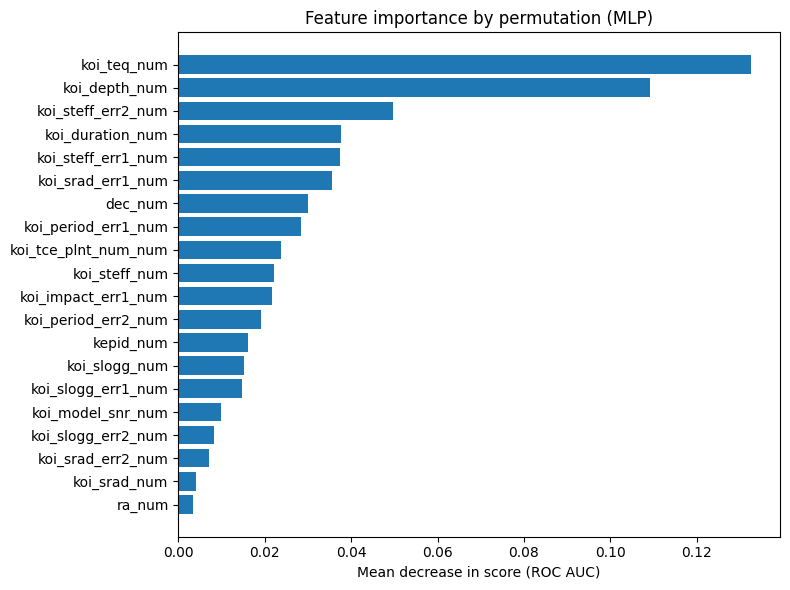


Comparativa (ordenada por weight_norm):
                 feature  weight_norm  perm_importance
0          koi_depth_num     2.585496         0.109197
1            koi_teq_num     2.142327         0.132626
2      koi_srad_err1_num     2.098260         0.035667
3     koi_slogg_err2_num     2.011198         0.008245
4          koi_steff_num     1.945396         0.022255
5    koi_impact_err1_num     1.877557         0.021611
6       koi_duration_num     1.868491         0.037728
7    koi_period_err1_num     1.821832         0.028423
8      koi_srad_err2_num     1.816386         0.007077
9     koi_slogg_err1_num     1.797926         0.014846
10  koi_tce_plnt_num_num     1.777122         0.023709
11                ra_num     1.758025         0.003476
12     koi_model_snr_num     1.746220         0.009906
13   koi_period_err2_num     1.711036         0.019201
14    koi_steff_err2_num     1.686310         0.049651
15               dec_num     1.574271         0.029895
16          koi_srad_num

In [42]:
# ============================================================
# 📌 Paso 10: Importancia de features (pesos de la primera capa + Permutation Importance)
# ============================================================
import os
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# directorio para guardar resultados
os.makedirs('models', exist_ok=True)
# 1) Importancia basada en la norma L2 de los pesos de la capa de entrada
# mlp.coefs_ es una lista de arrays: (n_features, n_hidden1), (n_hidden1, n_hidden2), ...
w0 = mlp.coefs_[0]  # forma: (n_features, n_hidden_neurons)
# calcular la norma L2 por fila (cada fila corresponde a una feature de entrada)
feature_weight_norm = np.linalg.norm(w0, axis=1)
features = list(X_train.columns)
df_w = pd.DataFrame({'feature': features, 'weight_norm': feature_weight_norm})
df_w = df_w.sort_values('weight_norm', ascending=False).reset_index(drop=True)
df_w.to_csv('models/feature_importances_by_weight.csv', index=False)
print('Guardado: models/feature_importances_by_weight.csv')
# Mostrar top 20
print('\nTop 20 features por norma de pesos:')
print(df_w.head(20))
# gráfica
plt.figure(figsize=(8,6))
plt.barh(df_w['feature'].head(20)[::-1], df_w['weight_norm'].head(20)[::-1])
plt.xlabel('L2 norm of input weights')
plt.title('Feature importance by input weight norm (MLP)')
plt.tight_layout()
plt.show()
# 2) Permutation Importance (usa el clasificador entrenado y el set de test escalado)
# Esto puede ser costoso; usamos n_repeats=10 por defecto
print('\nComputando Permutation Importance (esto puede tardar)...')
r = permutation_importance(mlp, X_test_s, y_test, n_repeats=10, random_state=42, scoring='roc_auc')
perm_means = r.importances_mean
df_p = pd.DataFrame({'feature': features, 'perm_importance': perm_means})
df_p = df_p.sort_values('perm_importance', ascending=False).reset_index(drop=True)
df_p.to_csv('models/feature_importances_by_permutation.csv', index=False)
print('Guardado: models/feature_importances_by_permutation.csv')
print('\nTop 20 features por Permutation Importance:')
print(df_p.head(20))
# gráfica
plt.figure(figsize=(8,6))
plt.barh(df_p['feature'].head(20)[::-1], df_p['perm_importance'].head(20)[::-1])
plt.xlabel('Mean decrease in score (ROC AUC)')
plt.title('Feature importance by permutation (MLP)')
plt.tight_layout()
plt.show()
# Mostrar comparación lado a lado para top features comunes
top_w = df_w['feature'].head(20).tolist()
top_p = df_p['feature'].head(20).tolist()
union_top = list(dict.fromkeys(top_w + top_p))[:30]  # mantener orden y limitar
cmp_df = pd.DataFrame({'feature': union_top})
cmp_df = cmp_df.merge(df_w[['feature','weight_norm']], on='feature', how='left')
cmp_df = cmp_df.merge(df_p[['feature','perm_importance']], on='feature', how='left')
print('\nComparativa (ordenada por weight_norm):')
print(cmp_df)
cmp_df.to_csv('models/feature_importances_comparison.csv', index=False)
print('Guardado: models/feature_importances_comparison.csv')
# Guardar el scaler y el modelo si se desea (ya importaste joblib) - opcional
# joblib.dump(mlp, 'models/mlp_model.joblib')
# joblib.dump(scaler, 'models/scaler.joblib')
print('\nListo. Revisa la carpeta models/ para los CSV y observa las gráficas arriba.')